# Mercari Price Prediction Project 
##  - Part 4 CNN with Word Embeddings and Overall Model Evaluations

With reference to the baseline CNN model without any word embedding that I built in part 3, in this section, I'm going to try pre-trained common bag of words (CBOW), skip-gram, word2vec combined both models, and GloVe as weights in deep learning embedding layers to see if I can improve the model performance.

## Import libraries

In [3]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy.random import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Activation, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers import concatenate, BatchNormalization
from keras import optimizers
from keras.models import Model
import pandas as pd
from tqdm import tqdm
import re
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
import multiprocessing
from sklearn.model_selection import train_test_split

import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
from tensorflow.keras.utils import plot_model

import pickle

## Import data

In [4]:
train = pd.read_csv('df_train.csv')
test = pd.read_csv('df_train.csv')
train.shape, test.shape

((1482535, 16), (1482535, 16))

## Process data

In [5]:
# split target variable and train dataset
y_train = train['log_price']
train.drop(['train_id','log_price'], axis=1, inplace=True)

In [6]:
# normalize numerical features using min-max normalization
cols = set(train.columns.values)
skip_cols = {'item_condition_id', 'brand_name',
  'shipping', 'item_description', 'main_cat',
  'subcat1', 'subcat2','name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result=df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

train = normalize(train)
test = normalize(test)

Normalizing following columns:  {'compound', 'desc_len', 'neutral', 'positive', 'name_len', 'negative'}


In [7]:
# text preprocessing 
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [8]:
def clean_cat(cat_values):
    '''takes categorical column values as arguments and returns list of cleaned categories'''
    
    catogories = list(cat_values)

    cat_list = []
    for i in tqdm(catogories):
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ','')
        i = i.replace('&','_')
        cat_list.append(i.strip())
    
    return cat_list

# Cleaning brand name before using count vectorizer
# Using same preprocessing as used earlier for categories: 'clean_cat()' function

train['brand_name'] = clean_cat(train['brand_name'].values)
test['brand_name'] = clean_cat(test['brand_name'].values)

100%|██████████| 1482535/1482535 [00:02<00:00, 548308.91it/s]


In [9]:
# encoding categorical variables for embedding
# use the same methods as in part3 to save some memories, better if we can use one-hot-encoding
label = LabelEncoder()

label.fit(train.brand_name) # brand name 
train.brand_name = label.transform(train.brand_name)

label.fit(train.main_cat) # sub_cat0
train.main_cat = label.transform(train.main_cat)

label.fit(train.subcat1) # sub_cat_1
train.subcat1 = label.transform(train.subcat1)

label.fit(train.subcat2) # sub_cat2
train.subcat2 = label.transform(train.subcat2)

del label

In [1]:
# # preprocessing 'item_description' for train set
# preprocessed_desc_train = []
# for sentance in train['item_description'].values:
#     sent = decontracted(sentance)
#     sent = sent.replace('\\r', ' ')
#     sent = sent.replace('\\"', ' ')
#     sent = sent.replace('\\n', ' ')
#     sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
#     sent = re.sub('[0-9]',' ',sent)
#     sent = re.sub('[^0-9A-Za-z]+',' ', sent)
#     sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
#     preprocessed_desc_train.append(sent.lower().strip())

# # after preprocesing
# preprocessed_desc_train[0]

In [11]:
# define function to preprocess texts
def preprocess_text(text_col):
    preprocessed_texts = []
    for sentence in tqdm(text_col.values):
        sent = decontracted(sentence)
        sent = sentence.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = re.sub('[0-9]',' ',sent)
        sent = re.sub('[^0-9A-Za-z]+',' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_texts.append(sent.lower().strip())
    return preprocessed_texts

# preprocess 'name' abd 'item_description' colunms
train['name'] = preprocess_text(train['name'])
test['name'] = preprocess_text(test['name'])
train['item_description'] = preprocess_text(train['item_description'])
test['item_description'] = preprocess_text(test['item_description'])

100%|██████████| 1482535/1482535 [01:55<00:00, 12798.58it/s]


## Train Word Embedding Models

### Skip-gram

In [12]:
# train skip-gram on 'name' column
tokens_name = train['name'].apply(lambda x: x.split()) # tokenizing text

In [13]:
# define skip-gram model (sg=1)
model_name = gensim.models.Word2Vec(tokens_name, min_count=1,size= 200,workers=3, window =3, sg = 1)

In [16]:
# train skip-gram word2vec on 'name' column in training dataset only to avoid data leakage
model_name.train(tokens_name,
                total_examples= len(tokens_name),
                epochs=10)

(52946933, 58652870)

In [15]:
# Define function to add/aggregate embeddings of single token text
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_name.wv[word].reshape((1, size))
            count += 1
        except KeyError:  # handling the case where the token is not in vocabulary
            count=0
    if count != 0:
        vec /= count
    return vec

In [15]:
# tokens_name_size=len(tokens_name)
# wordvec_train_name = np.zeros([tokens_name_size, 200]) 
# # wordvec_test_array = np.zeros((test_tokens_size, 200))

# for i in range(tokens_name_size):
#     try:
#         wordvec_train_name[i,:] = word_vector(tokens_name[i], 200)
#     except KeyError: 
#         continue

In [16]:
# check model sanity using similar words
model_name.wv.most_similar(positive="girls")

[('girl', 0.6978934407234192),
 ('toddler', 0.6608414649963379),
 ('boys', 0.6361578106880188),
 ('toddlers', 0.6250782012939453),
 ('tcp', 0.6128557324409485),
 ('gymbo', 0.6030761003494263),
 ('mons', 0.6022695302963257),
 ('toodler', 0.6001339554786682),
 ('mths', 0.599035918712616),
 ('healthtex', 0.5898845195770264)]

In [18]:
model_name.wv.most_similar(positive="aj")

[('placetoshop', 0.5386506915092468),
 ('mello', 0.5337939262390137),
 ('strowman', 0.5310925841331482),
 ('nenee', 0.5171169638633728),
 ('cermony', 0.5167869925498962),
 ('infread', 0.5166544914245605),
 ('anothabadcreation', 0.5164967179298401),
 ('dorenbecher', 0.5162520408630371),
 ('beckett', 0.515447735786438),
 ('failed', 0.5137488842010498)]

In [20]:
# start skip-gram on 'item_description' column
tokens_desc = train['item_description'].apply(lambda x: x.split()) # tokenizing text

In [21]:
# define skip-gram model (sg=1)
model_desc = gensim.models.Word2Vec(tokens_desc, min_count=1,size= 200,workers=3, window =3, sg = 1)

In [22]:
# train skip-gram word2vec on 'item_description' column in training dataset only to avoid data leakage
model_desc.train(tokens_desc,
                total_examples= len(tokens_desc),
                epochs=10)

(227631512, 253780680)

In [25]:
# check model sanity using similar words
model_desc.wv.most_similar(positive="girls")

[('boys', 0.7316703796386719),
 ('girl', 0.6686173677444458),
 ('toddler', 0.654719889163971),
 ('kids', 0.6462230086326599),
 ('josmo', 0.6004785299301147),
 ('lass', 0.5925391912460327),
 ('dotdot', 0.5912953615188599),
 ('colthes', 0.5858153700828552),
 ('gymboree', 0.583824098110199),
 ('sleepwears', 0.5833008289337158)]

### Common Bag of Words (CBOW)

In [14]:
# train CBOW on 'name' column, define function (sg=0)
model_name_2 = gensim.models.Word2Vec(tokens_name, min_count=1,size= 200,workers=3, window =3, sg = 0)

In [15]:
# train CBOW word2vec on 'name' column in training dataset only to avoid data leakage
model_name_2.train(tokens_name,
                total_examples= len(tokens_name),
                epochs=10)

(52947124, 58652870)

In [17]:
# check model sanity using similar words
model_name_2.wv.most_similar(positive="girls")

[('girl', 0.6457170248031616),
 ('boys', 0.6232644319534302),
 ('kids', 0.5644568800926208),
 ('infants', 0.5503854155540466),
 ('toddler', 0.5246853828430176),
 ('toddlers', 0.5245176553726196),
 ('womens', 0.5030124187469482),
 ('boy', 0.4984321892261505),
 ('women', 0.4865603446960449),
 ('months', 0.4725039303302765)]

In [19]:
model_name_2.wv.most_similar(positive="aj")

[('zach', 0.5825031399726868),
 ('placetoshop', 0.5449240803718567),
 ('chasity', 0.5431110858917236),
 ('lows', 0.516444206237793),
 ('prizm', 0.5138728618621826),
 ('raptor', 0.5135284066200256),
 ('stanton', 0.5111625790596008),
 ('shaquille', 0.5098451375961304),
 ('giancarlo', 0.502946138381958),
 ('neal', 0.49687549471855164)]

In [23]:
# train CBOW on 'item_description' column, define function (sg=0)
model_desc_2 = gensim.models.Word2Vec(tokens_desc, min_count=1,size= 200,workers=3, window =3, sg = 0)

In [24]:
# train CBOW word2vec on 'item_description' column in training dataset only to avoid data leakage
model_desc_2.train(tokens_desc,
                total_examples= len(tokens_desc),
                epochs=10)

(227631154, 253780680)

In [26]:
# check model sanity using similar words
model_desc_2.wv.most_similar(positive="girls")

[('boys', 0.6656105518341064),
 ('girl', 0.61686772108078),
 ('kids', 0.6155326962471008),
 ('toddler', 0.5794589519500732),
 ('ladies', 0.5690403580665588),
 ('juniors', 0.5352164506912231),
 ('jumpers', 0.505829930305481),
 ('kid', 0.4887089133262634),
 ('naartjie', 0.4874405264854431),
 ('crewcuts', 0.48140695691108704)]

## Construct embedding layers with different word embeddings

In [27]:
# define a function to construct a sort of dictionary I can extract the word vectors from
def embedding_index(embed_dict,m):    
    for w in m.wv.vocab.keys():
        embed_dict[w] = m.wv[w]
    print('Found %s word vectors.' % len(embed_dict))

### For skip-gram

In [32]:
# for 'name'
embeddings_index_n = {}
embedding_index(embeddings_index_n,model_name)

Found 90623 word vectors.


In [33]:
# for 'item_description'
embeddings_index_id = {}
embedding_index(embeddings_index_id,model_desc)

Found 129523 word vectors.


### For CBOW

In [30]:
# for 'name'
embeddings_index_n2 = {}
embedding_index(embeddings_index_n2,model_name_2)

Found 90623 word vectors.


In [31]:
# for 'item_description'
embeddings_index_id2 = {}
embedding_index(embeddings_index_id2,model_desc_2)

Found 129523 word vectors.


### For concatenated vectors of the two models
For each model, I have 200 dimension vector representation of the words, and by concatenating each word will have 400 dimension vector representation.

In [28]:
# for 'name'
embeddings_index_n3 = {}
for w in model_name.wv.vocab.keys():
    embeddings_index_n3[w] = np.append(model_name.wv[w],model_name_2.wv[w])
print('Found %s word vectors.' % len(embeddings_index_n3))

Found 90623 word vectors.


In [29]:
# for 'item_description'
embeddings_index_id3 = {}
for w in model_desc.wv.vocab.keys():
    embeddings_index_id3[w] = np.append(model_desc.wv[w],model_desc_2.wv[w])
print('Found %s word vectors.' % len(embeddings_index_id3))

Found 129523 word vectors.


## Tokenization
Now we have our reference to word vectors ready, but we still haven't prepared data to be in the format I have explained at the start of the post. Keras' 'Tokenizer' will split each word in a sentence, then we can call 'texts_to_sequences' method to get the sequential representation of each sentence. We also need to pass 'num_words' which is a number of vocabularies you want to use, and this will be applied when you call 'texts_to_sequences' method. This might be a bit counter-intuitive since if you check the length of all the word index, it will not be the number of words you defined, but the actual screening process happens when you call 'texts_to_sequences' method.

In [23]:
# text to Sequence Data.
# combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])
# full_text_test = np.hstack([test.item_description.str.lower(), test.name.str.lower()])

In [24]:
# tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower())

## Prepare word vectors to feed the model
Before we can feed the sequential text data to a model, we need to build a matrix of these word vectors using the word index number so that our model can refer to the corresponding vector when fed with integer sequence. This is because when we transformed a sentence into a sequence, each word is represented by an integer number, and these numbers are where each word is stored in the tokenizer's word index.

### Define function for transformation
I am defining the number of words to be 200000. This means I will only care about 200000 most frequent words in the training set.

In [36]:
num_words = 200000
def embedding_matrix(embedind):
    embedding_matrix= np.zeros((num_words, 200))
    for word, i in tokenizer.word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embedind.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        return embedding_matrix

### For skip-gram

In [39]:
# for 'name'
embedding_matrix_n= embedding_matrix(embeddings_index_n)

In [40]:
# for 'item_description'
embedding_matrix_id = embedding_matrix(embeddings_index_n)

### For CBOW

In [37]:
# for 'name'
embedding_matrix_n_2 = embedding_matrix(embeddings_index_n2)

In [38]:
# for 'item_description'
embedding_matrix_id_2 = embedding_matrix(embeddings_index_id2)

### For combined word vectors

In [41]:
# for 'name'
embedding_matrix_n_3 = np.zeros((num_words, 400))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index_n3.get(word)
    if embedding_vector is not None:
        embedding_matrix_n_3[i] = embedding_vector

In [42]:
# for 'item_description'
embedding_matrix_id_3 = np.zeros((num_words, 400))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index_id3.get(word)
    if embedding_vector is not None:
        embedding_matrix_id_3[i] = embedding_vector

### For GloVe
Here, I used pretrained GloVe model from Stanford which contains 300-dimensional vectors for 0.4 million words and phrases.

In [21]:
# load the whole embedding into memory
embedding_glove = './glove.6B/glove.6B.300d.txt'
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index_glove = dict(get_coefs(*o.split(" ")) for o in open(embedding_glove))

In [61]:
# create a weight matrix for words in training docs
embedding_matrix_glove = np.zeros((200000, 300))
for word, index in tokenizer.word_index.items():
    if index > 200000 - 1:
        break
    else:
        embedding_vector = embeddings_index_glove.get(word)
        if embedding_vector is not None:
            embedding_matrix_glove[index] = embedding_vector

In [33]:
# finding out max len of all the text data combineds
max_len_brand = np.max(train.brand_name.max())    # brand 
max_len_condition = np.max(int(max(train.item_condition_id)))  # item_condition
max_len_desc = np.max(int(train.desc_len.max()))  # desc_len
max_len_name = np.max(int(train.name_len.max()))  # name_len
max_len_sub0 = np.max(int(train.main_cat.max()))  # main_cat
max_len_sub1 = np.max(int(train.subcat1.max()))  # Sub_1
max_len_sub2 = np.max(train.subcat2.max())  # Sub_2
# defining max length for padding text data.
name_padding = 15
description_padding = 80
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),])

In [50]:
# train and test split
x_tr, x_te, Y_train, Y_test = train_test_split(train,y_train, random_state=42, train_size=0.7)
Y_train = Y_train.values.reshape(-1, 1)
Y_test = Y_test.values.reshape(-1, 1)

## CNN Models

### Using Skip-gram only

In [32]:
# padding
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= 200),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= 200),
"brand_name" : np.array(x_tr.brand_name),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.main_cat),
"subcat_1"  : np.array(x_tr.subcat1),
"subcat_2" : np.array(x_tr.subcat2),
} 
x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= 200),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= 200),
"brand_name" : np.array(x_te.brand_name),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.main_cat),
"subcat_1" : np.array(x_te.subcat1),
"subcat_2" : np.array(x_te.subcat2),
}

In [33]:
x_tr = x_train_padded
x_te = x_test_padded

In [34]:
# define attributes
batch_size = 512 * 3
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(x_tr['name']) / batch_size) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

In [45]:
# definign inputs
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name = Input(shape=[1], name="brand_name")

num_vars = Input(shape=[1], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(200, name="name") # 15 shape = [15]
item_desc = Input(200, name="item_desc") # 80 shape = [80]

In [36]:
# define embedding layers, max lengthes raised larger becuase of the system error using tensorflow 2.x
sub0_emb = Embedding(max_len_sub0+10, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1+10, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2+10, 10)(subcat_2)

brand_emb = Embedding(max_len_brand+10, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition+10, 5)(item_condition)

name_emb = Embedding(200000, 200, weights=[embedding_matrix_n],input_length=name_padding, trainable=True)(name)
item_desc_emb = Embedding(200000, 200, weights=[embedding_matrix_id],input_length=description_padding, trainable=True)(item_desc)

desc_len_emb = Embedding(max_len_desc+10, 5)(desc_len)
name_len_emb = Embedding(max_len_name+10, 5)(name_len)

In [37]:
# cnn and pooling layers
convs1 = []
convs2 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

In [38]:
convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

In [53]:
# flatten
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [40]:
# concatenate for further steps
main_l = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1,convs2, num_vars])

In [41]:
# add dropout and batchnormalization layers
main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

In [42]:
# define output layer and optimizer
output = Dense(1, activation="linear") (main_l)
model1= Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars], output)
optimizer = optimizers.Adam(lr = 0.005)
# compile the model
model1.compile(loss = 'mse', optimizer = optimizer)
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 200)     40000000    name[0][0]                       
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 200)     40000000    item_desc[0][0]                  
_______________________________________________________________________________________

In [43]:
# fit cnn model
model1.fit(x_tr, Y_train, epochs= 2, batch_size= 512 * 3)

Epoch 1/2
676/676 [==============================] - 1274s 2s/step - loss: 0.5506
Epoch 2/2
676/676 [==============================] - 1156s 2s/step - loss: 0.1831


In [70]:
def rmsle(y, y_pred): # return Rmsle value.
    return np.sqrt(np.mean(np.square(y_pred - y )))

In [46]:
# get the error
y_pred = model1.predict(x_te, batch_size=batch_size)
print("RMSLE error:", rmsle(Y_test, y_pred))

RMSLE error: 0.44352263135055897


### Using CBOW only

In [68]:
# redefine name and item description embeddings using trained CBOW as different weights
# paddings and other embedding layers can remain the same because only the weights changed
name_emb_2 = Embedding(200000, 200, weights=[embedding_matrix_n_2],input_length=name_padding, trainable=True)(name)
item_desc_emb_2 = Embedding(200000, 200, weights=[embedding_matrix_id_2],input_length=description_padding, trainable=True)(item_desc)

In [92]:
# cnn and pooling layers
convs1_2 = []
convs2_2 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb_2)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb_2)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1_2.append(maxpool1)
  convs2_2.append(maxpool2)

In [71]:
convs1_2 = concatenate(convs1_2)
convs2_2 = concatenate(convs2_2)

In [41]:
# flatten
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [73]:
# concatenate for further steps
main_2 = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1_2,convs2_2, num_vars])

In [74]:
# add dropout and batchnormalization layers
main_2 = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_2))
main_2 = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_2))
main_2 = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_2))
main_2 = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_2))

In [75]:
# define output layer and optimizer
output_2 = Dense(1, activation="linear") (main_2)
model2 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars], output_2)
optimizer = optimizers.Adam(lr = 0.005)
# compile the model
model2.compile(loss = 'mse', optimizer = optimizer)
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 200, 200)     40000000    name[0][0]                       
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 200, 200)     40000000    item_desc[0][0]                  
_______________________________________________________________________________________

In [76]:
# fit cnn model
model2.fit(x_tr, Y_train, epochs= 2, batch_size= 512 * 3)

Epoch 1/2
676/676 [==============================] - 1299s 2s/step - loss: 0.5596
Epoch 2/2
676/676 [==============================] - 1296s 2s/step - loss: 0.1849


In [77]:
# get the error
y_pred = model2.predict(x_te, batch_size=batch_size)
print("RMSLE error:", rmsle(Y_test, y_pred))

RMSLE error: 0.4517581166409557


### Using combined word2vectors

In [46]:
# padding
# we need new paddings here because the shape of the embedding matrix changed
x_train_padded_con = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= 400),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= 400),
"brand_name" : np.array(x_tr.brand_name),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.main_cat),
"subcat_1"  : np.array(x_tr.subcat1),
"subcat_2" : np.array(x_tr.subcat2),
} 
x_test_padded_con = {
"name" : pad_sequences(x_te.seq_name, maxlen= 400),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= 400),
"brand_name" : np.array(x_te.brand_name),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.main_cat),
"subcat_1" : np.array(x_te.subcat1),
"subcat_2" : np.array(x_te.subcat2),
}

In [47]:
x_tr = x_train_padded_con
x_te = x_test_padded_con

In [48]:
# define attributes
batch_size = 512 * 3
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(x_tr['name']) / batch_size) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)
# definign inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name = Input(shape=[1], name="brand_name")

num_vars = Input(shape=[1], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

# inputs should change the shape as well in accordance with the embedding_matrix's shape
name_con = Input(400, name="name") # 15 shape = [15]
item_desc_con = Input(400, name="item_desc") # 80 shape = [80]

In [62]:
# define embedding layers, max lengthes raised larger becuase of the system error using tensorflow 2.x
sub0_emb = Embedding(max_len_sub0+10, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1+10, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2+10, 10)(subcat_2)

brand_emb = Embedding(max_len_brand+10, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition+10, 5)(item_condition)



desc_len_emb = Embedding(max_len_desc+10, 5)(desc_len)
name_len_emb = Embedding(max_len_name+10, 5)(name_len)

# to fit inputs and weightings in, change the shape to 400
name_emb_con = Embedding(200000, 400, weights=[embedding_matrix_n_3],input_length=name_padding, trainable=True)(name_con)
item_desc_emb_con = Embedding(200000, 400, weights=[embedding_matrix_id_3],input_length=description_padding, trainable=True)(item_desc_con)

In [63]:
# cnn and pooling layers
convs1_3 = []
convs2_3 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=100, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb_con)
  cnn_layer2 = Conv1D(filters=100, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb_con)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1_3.append(maxpool1)
  convs2_3.append(maxpool2)
# cnn and pooling layers
convs1_3 = concatenate(convs1_3)
convs2_3 = concatenate(convs2_3)

In [42]:
# flatten
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [64]:
# concatenate for further steps
main_3 = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1_3,convs2_3, num_vars])

In [65]:
# add dropout and batchnormalization layers
main_3 = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_3))
main_3 = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_3))
main_3 = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_3))
main_3 = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_3))

In [66]:
# define output layer and optimizer
output_3 = Dense(1, activation="linear") (main_3)
model3 = Model([name_con, item_desc_con, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars], output_3)
optimizer = optimizers.Adam(lr = 0.005)
# compile the model
model3.compile(loss = 'mse', optimizer = optimizer)
model3.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 400)]        0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 400, 400)     80000000    name[0][0]                       
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 400, 400)     80000000    item_desc[0][0]                  
_______________________________________________________________________________________

In [67]:
# fit cnn model
model3.fit(x_tr, Y_train, epochs= 2, batch_size= 512 * 3)

Epoch 1/2
676/676 [==============================] - 12969s 19s/step - loss: 0.5378
Epoch 2/2
676/676 [==============================] - 12520s 19s/step - loss: 0.1876


In [69]:
# get the error
y_pred = model3.predict(x_te, batch_size=batch_size)
print("RMSLE error:", rmsle(Y_test, y_pred))

RMSLE error: 0.453948998016969


### Using Pre-trained GloVe embedding

In [51]:
# padding glove
# change shape to 300 to keep up with the embedding matrix's shape
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= 300),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= 300),
"brand_name" : np.array(x_tr.brand_name),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.main_cat),
"subcat_1"  : np.array(x_tr.subcat1),
"subcat_2" : np.array(x_tr.subcat2),
} 
x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= 300),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= 300),
"brand_name" : np.array(x_te.brand_name),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.main_cat),
"subcat_1" : np.array(x_te.subcat1),
"subcat_2" : np.array(x_te.subcat2),
}

In [52]:
x_tr = x_train_padded
x_te = x_test_padded

In [30]:
# define attributes
batch_size = 512 * 3
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(x_tr['name']) / batch_size) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

In [53]:
# definign inputs
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name = Input(shape=[1], name="brand_name")

num_vars = Input(shape=[1], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

# change shape to 300
name = Input(300, name="name") # 15 shape = [15]
item_desc = Input(300, name="item_desc") # 80 shape = [80]

In [62]:
# define embedding layers, max lengthes raised larger becuase of the system error using tensorflow 2.x
sub0_emb = Embedding(max_len_sub0+10, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1+10, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2+10, 10)(subcat_2)

brand_emb = Embedding(max_len_brand+10, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition+10, 5)(item_condition)
# change shape to 300 to use glove weightings and new defined inputs
name_emb = Embedding(200000, 300, weights=[embedding_matrix_glove],input_length=name_padding, trainable=True)(name)
item_desc_emb = Embedding(200000, 300, weights=[embedding_matrix_glove],input_length=description_padding, trainable=True)(item_desc)

desc_len_emb = Embedding(max_len_desc+10, 5)(desc_len)
name_len_emb = Embedding(max_len_name+10, 5)(name_len)

In [63]:
# cnn and pooling layers
convs1_4 = []
convs2_4 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=100, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=100, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1_4.append(maxpool1)
  convs2_4.append(maxpool2)
# cnn and pooling layers
convs1_4 = concatenate(convs1_4)
convs2_4 = concatenate(convs2_4)

In [64]:
# flattem
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [65]:
# concatenate for further steps
main_4 = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1_4,convs2_4, num_vars])

In [66]:
# add dropout and batchnormalization layers
main_4 = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_4))
main_4 = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_4))
main_4 = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_4))
main_4 = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_4))

In [67]:
# define output layer and optimizer
output_4 = Dense(1, activation="linear") (main_4)
model4 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars], output_4)
optimizer = optimizers.Adam(lr = 0.005)
# compile the model
model4.compile(loss = 'mse', optimizer = optimizer)
model4.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               [(None, 300)]        0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_43 (Embedding)        (None, 300, 300)     60000000    name[0][0]                       
__________________________________________________________________________________________________
embedding_44 (Embedding)        (None, 300, 300)     60000000    item_desc[0][0]                  
_______________________________________________________________________________________

In [68]:
# fit cnn model
model4.fit(x_tr, Y_train, epochs= 2, batch_size= 512 * 3)

Epoch 1/2
676/676 [==============================] - 3304s 5s/step - loss: 0.5475
Epoch 2/2
676/676 [==============================] - 3406s 5s/step - loss: 0.1826


In [71]:
# get the error
y_pred = model4.predict(x_te, batch_size=batch_size)
print("RMSLE error:", rmsle(Y_test, y_pred))

RMSLE error: 0.4685206355815177


## Plot the model 
I plot the skip-gram model as an example to show the baseline structure of my CNN models as below.

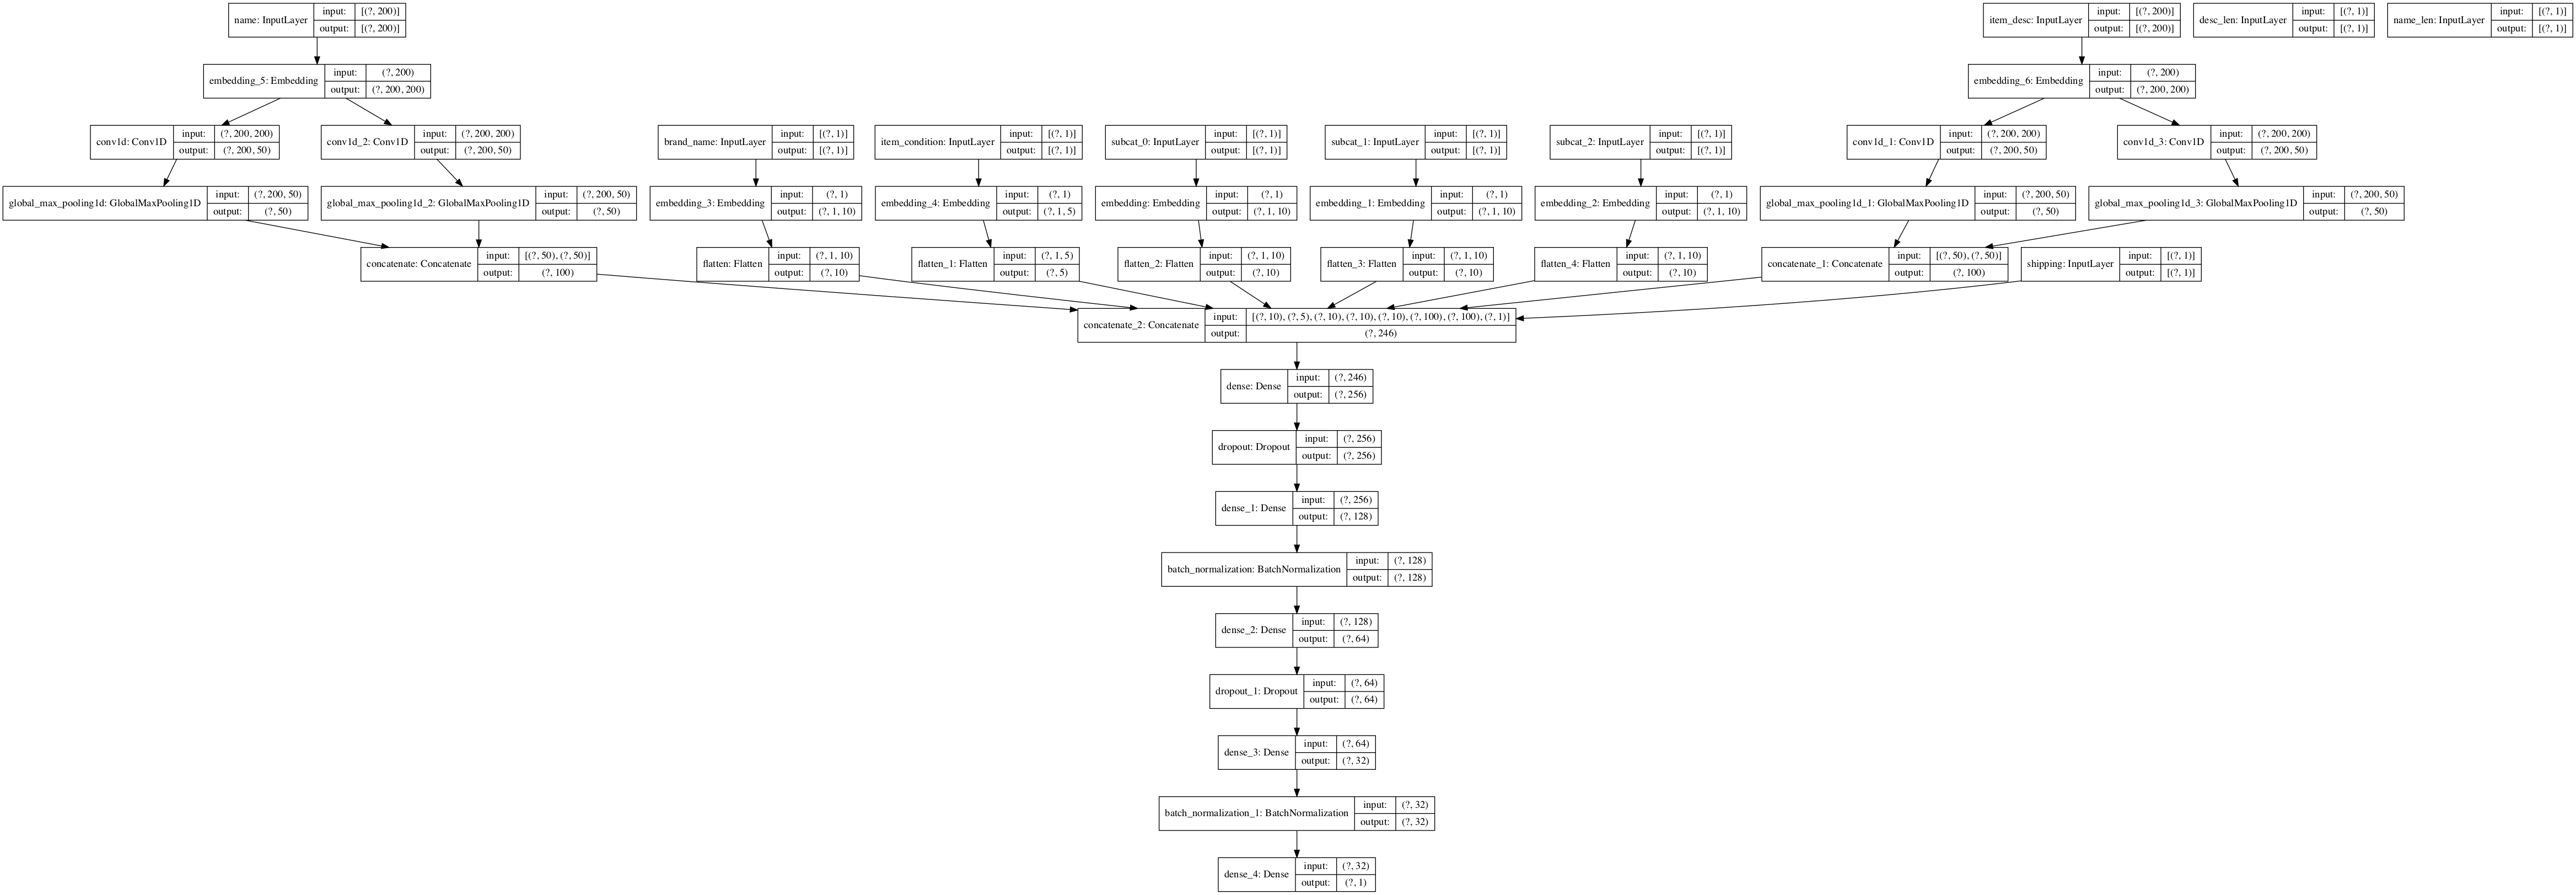

In [47]:
plot_model(model1, to_file= 'CNN_wv2.png', show_shapes=True, show_layer_names=True)
Image(filename='CNN_wv2.png')

In [49]:
model_json = model_2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model_2.save_weights("model.h5")

## Model comparison

In [6]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "RMSLE Error"]
x.add_row(["Ridge Regressrion", 0.48])
x.add_row(["Lasso Regressrion", 0.56])
x.add_row(["Light GBM", 0.49])
x.add_row(["XGBoost", 0.58])
x.add_row(["Baseline CNN", 0.45])
x.add_row(["CNN + Skip-gram", 0.44])
x.add_row(["CNN + CBOW", 0.45])
x.add_row(["CNN + Combined Word2Vec", 0.45])
x.add_row(["CNN + Pretrained GloVe", 0.47])

print(x)

+-------------------------+-------------+
|          Model          | RMSLE Error |
+-------------------------+-------------+
|    Ridge Regressrion    |     0.48    |
|    Lasso Regressrion    |     0.56    |
|        Light GBM        |     0.49    |
|         XGBoost         |     0.58    |
|       Baseline CNN      |     0.45    |
|     CNN + Skip-gram     |     0.44    |
|        CNN + CBOW       |     0.45    |
| CNN + Combined Word2Vec |     0.45    |
|  CNN + Pretrained GloVe |     0.47    |
+-------------------------+-------------+


**Findings:**
<br> Implementing word embeddings as weighting in CNN model did not improve model performance significantly, while made the model slower to run. One probability is that these pretrained embeddings are not trained against text in the same context so the number of common words between our text and text that these pretrained embeddings were trained would be low. One way to solve this is to use a large corpus to train the word embeddings, and the other way is to reduce the overfitting in the baseline model or try early stopping.
<br>
<br> From the perspective of business needs, I would recommende the baseline CNN model as it gets the lowest RMSLE error in my experiments, it runs a lot faster than any other models, and it is easy to update with new data to improve/maintainence the model in a regular base.

## Future work

<br> 1. With reference to other kerneks, there are several feature engineering techniques to further reduce the score. For example, we can introduce aggregated features into the model (mean item description length), or remove some features we generated that has little impact after experiments (name length).
<br>
<br> 2. We can also implement deeper neural network with better architecture and hyper parameter tuning.And it is worth trying multi-layer perceptron as it handles short text data and categorical features well or LSTM as it learns better than a 2-layer only CNN. Anyway, we should keep in mind that the model should be efficient as well, so a LSTM would be the most worthy experiment to do.
